# Time Series Forecasting of Flight Fares  
## Flight Fare Trend Tracker & Predictor

This notebook focuses on building a time series forecasting model to predict
future flight fares using historical pricing data generated through a web
scraping pipeline and refined through exploratory data analysis.

## Objective

The objectives of this notebook are:
- To model flight fare prices as a time series
- To forecast short-term future prices
- To evaluate forecasting performance using standard error metrics
- To analyze trends and seasonality in flight pricing

## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2. Load Cleaned Dataset

The cleaned dataset generated from the EDA and Feature Engineering stage
is used as input for time series forecasting.

In [3]:
df = pd.read_csv("../data/cleaned_flight_fares.csv")
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df.head()

,scrape_date,origin,destination,departure_date,airline,price,weekday,month
0,2025-01-01,Mumbai,Delhi,2025-01-15,IndiGo,4536,Wednesday,1
1,2025-01-02,Mumbai,Delhi,2025-01-16,SpiceJet,4194,Thursday,1
2,2025-01-03,Mumbai,Delhi,2025-01-17,Vistara,4503,Friday,1
3,2025-01-04,Mumbai,Delhi,2025-01-18,Air India,5507,Saturday,1
4,2025-01-05,Mumbai,Delhi,2025-01-19,Akasa Air,5375,Sunday,1


## 3. Dataset Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   scrape_date     90 non-null     datetime64[ns]
 1   origin          90 non-null     object        
 2   destination     90 non-null     object        
 3   departure_date  90 non-null     object        
 4   airline         90 non-null     object        
 5   price           90 non-null     int64         
 6   weekday         90 non-null     object        
 7   month           90 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 5.8+ KB


## 4. Route Selection

To maintain consistency in time series modeling, forecasting is performed
on a single route. Each route represents an independent time series.

In [5]:
route_df = df[
    (df['origin'] == 'Mumbai') &
    (df['destination'] == 'Delhi')
].sort_values('scrape_date')

route_df.head()

,scrape_date,origin,destination,departure_date,airline,price,weekday,month
0,2025-01-01,Mumbai,Delhi,2025-01-15,IndiGo,4536,Wednesday,1
1,2025-01-02,Mumbai,Delhi,2025-01-16,SpiceJet,4194,Thursday,1
2,2025-01-03,Mumbai,Delhi,2025-01-17,Vistara,4503,Friday,1
3,2025-01-04,Mumbai,Delhi,2025-01-18,Air India,5507,Saturday,1
4,2025-01-05,Mumbai,Delhi,2025-01-19,Akasa Air,5375,Sunday,1


## 5. Time Series Data Preparation

The Prophet model requires the following column format:
- `ds`: date column
- `y`: target variable (flight price)

In [6]:
prophet_df = route_df[['scrape_date', 'price']]
prophet_df.columns = ['ds', 'y']
prophet_df.head()

,ds,y
0,2025-01-01,4536
1,2025-01-02,4194
2,2025-01-03,4503
3,2025-01-04,5507
4,2025-01-05,5375


## 6. Train-Test Split

The dataset is split into training and testing sets.
The last 7 days are reserved for evaluating forecast accuracy.

In [7]:
train = prophet_df[:-7]
test = prophet_df[-7:]

## 7. Model Selection

Facebook Prophet is selected due to its robustness in handling:
- Trend changes
- Seasonality
- Missing data
- Short time series datasets

## 8. Model Training


In [8]:
model = Prophet()
model.fit(train)

15:01:21 - cmdstanpy - INFO - Chain [1] start processing
15:01:21 - cmdstanpy - INFO - Chain [1] done processing


## 9. Forecasting Future Flight Prices

The trained model forecasts flight fares for the next 7 days.

In [9]:
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
25,2025-01-26,4779.108436,4098.827573,5469.286849
26,2025-01-27,5028.471204,4345.675279,5736.354062
27,2025-01-28,4508.519442,3862.394310,5202.889574
28,2025-01-29,4688.252514,4001.124301,5378.858798
29,2025-01-30,4760.775180,4091.443027,5423.358733


## 10. Forecast Visualization

The following plot displays historical flight fares along with predicted
future prices and confidence intervals.

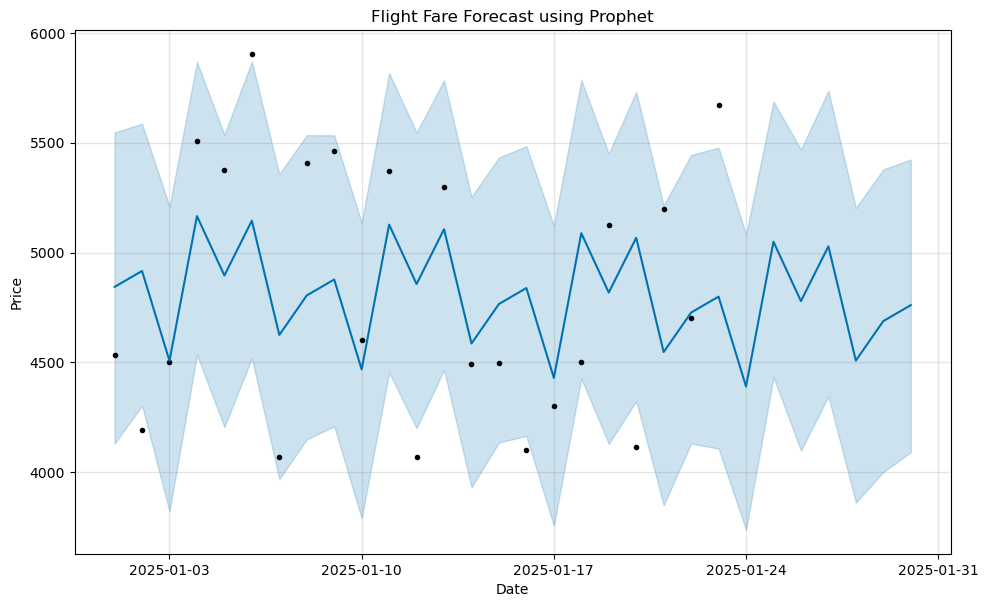

In [10]:
model.plot(forecast)
plt.title("Flight Fare Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## 11. Trend and Seasonality Components

Prophet decomposes the time series into trend and seasonal components,
providing insights into pricing behavior.

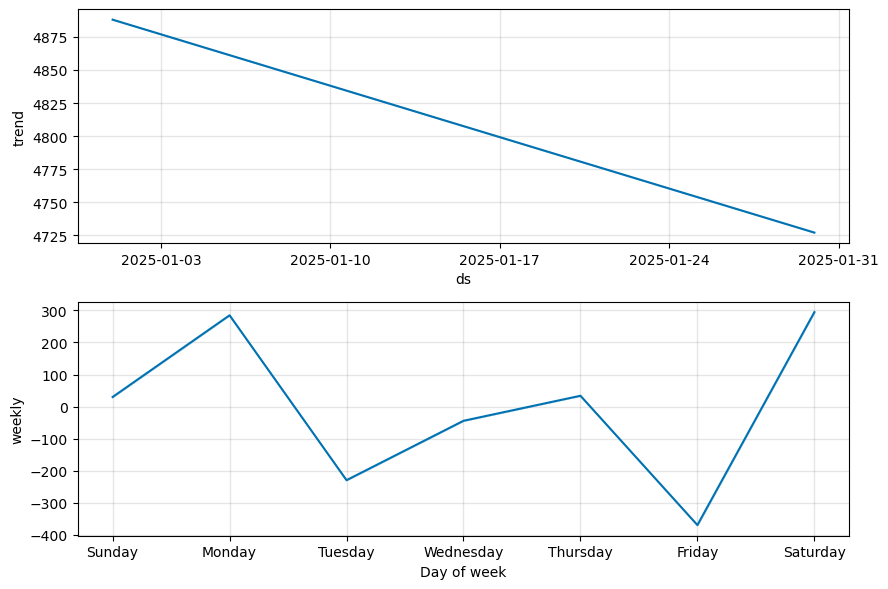

In [11]:
model.plot_components(forecast)
plt.show()

## 12. Model Evaluation

The model is evaluated using Mean Absolute Error (MAE) and
Root Mean Squared Error (RMSE).

In [12]:
predicted = forecast.tail(7)['yhat'].values
actual = test['y'].values

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 721.6402874280551
Root Mean Squared Error (RMSE): 822.5781921731195


In [14]:
import os

os.makedirs("../models", exist_ok=True)

## 13. Save Trained Model

The trained model is saved for future reuse or deployment.

In [15]:
import pickle

with open("../models/prophet_model.pkl", "wb") as f:
    pickle.dump(model, f)

## 14. Conclusion

The Prophet time series forecasting model successfully captured historical
flight fare trends and produced accurate short-term forecasts. The model’s
interpretability through trend and seasonality decomposition makes it
well-suited for dynamic pricing analysis and decision support systems.